# <center>  Deep Neural Network (DNN) using plain TensorFlow

### Regularization of DNN [256,256,256,256] with l1 regularization

## <font color = 'blue'> Get the data

In [6]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import defaultdict
from time import time
from functools import partial

%store -r
%store

Stored variables and their in-db values:
X_32test_std              -> defaultdict(<class 'list'>, {0: array([[ 0.7957011
X_32train_std             -> array([[-0.44445615,  0.62874736, -0.19049071, ...
X_test                    -> defaultdict(<class 'list'>, {0: array([[[-0.004097
X_test_std                -> defaultdict(<class 'list'>, {0: array([[ 0.8784659
X_train                   -> array([[[-0.00304779,  0.0030504 , -0.00249425, ..
X_train_std               -> array([[-0.44445615,  0.62874736, -0.19049071, ...
snrs                      -> [-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 
y_32_test                 -> defaultdict(<class 'list'>, {0: array([6, 7, 1, ..
y_32_train                -> array([7, 2, 4, ..., 5, 5, 3])
y_test                    -> defaultdict(<class 'list'>, {0: array([3, 2, 5, ..
y_train                   -> array([7, 2, 4, ..., 5, 5, 3])


In [7]:
print("Training data: ", X_32train_std.shape, "and labels: ", y_32_train.shape)
print(" ")
print("Test data:")
print("Total", len(X_32test_std), X_32test_std[18].shape, "arrays for SNR values:")
print(sorted(X_32test_std.keys()))

Training data:  (80000, 32) and labels:  (80000,)
 
Test data:
Total 20 (4000, 32) arrays for SNR values:
[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]


In [8]:
# tf.reset_default_graph()

## <font color='blue'> Create validation set required for early stopping

In [9]:
X_val = []
y_val = []

X_test_new = defaultdict(list)
y_test_new = defaultdict(list)

for snr in snrs:
    n_test = X_32test_std[snr].shape[0]
    X_val.append(X_32test_std[snr][:(n_test*0.5)])
    y_val.append(y_32_test[snr][:(n_test*0.5)])
    X_test_new[snr] = X_32test_std[snr][(n_test*0.5):]
    y_test_new[snr] = y_32_test[snr][(n_test*0.5):]
    
X_val = np.vstack(np.asarray(X_val))
y_val =np.hstack(np.asarray(y_val))

print("Validation set data", X_val.shape, "and labels", y_val.shape)

X_32test_std = X_test_new
y_32_test = y_test_new
X_32_val = X_val 
y_32_val = y_val

Validation set data (40000, 32) and labels (40000,)


## <font color = 'blue'> Design and train the DNN

In [11]:
# ----------------- Initialize parameters -----------------------


n_hidden1 = 256
n_hidden2 = 256
n_hidden3 = 256
n_hidden4 = 256

n_outputs = 8

X = tf.placeholder(tf.float32, shape=(None, 32))
y = tf.placeholder(tf.int64, shape=(None))
training_ = tf.placeholder_with_default(False, shape=[])

weight_init = tf.contrib.layers.xavier_initializer()
activation_func = tf.nn.elu

# ------------------- Define layers -----------------------

from tensorflow.contrib.layers import fully_connected

scale_val = 0.001
new_dense_layer = partial(tf.layers.dense, kernel_initializer = weight_init,
                          kernel_regularizer = tf.contrib.layers.l1_regularizer(scale_val), 
                          activation = activation_func)

dense_layer1 = new_dense_layer(X, n_hidden1)

dense_layer2 = new_dense_layer(dense_layer1, n_hidden2)

dense_layer3 = new_dense_layer(dense_layer2, n_hidden3)

dense_layer4 = new_dense_layer(dense_layer3, n_hidden4)

logits = tf.layers.dense(dense_layer4, n_outputs)

# ----------------- Specify performance measure ----------------------

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
loss = tf.reduce_mean(xentropy)

optimizer = tf.train.AdamOptimizer()
training_op = optimizer.minimize(loss)

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        
# ------------------ Execution phase ----------------------------------    

n_epochs = 1000
batch_size = 1024
n_train = X_train_std.shape[0]
n_iter = n_train//batch_size

saver = tf.train.Saver()

min_loss = np.infty
epochs_without_improvement = 0 
max_epochs_without_improvement = 20   

acc_test = defaultdict(list)

start = time()
path = "./DNN4layer_regtech_l1"

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    for epoch in range(n_epochs):
        for iteration in range(n_iter):
            rand_indices = np.random.choice(n_train,batch_size) #select random samples to form mini batches   
            X_batch, y_batch = X_32train_std[rand_indices], y_32_train[rand_indices]
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch,  training_: True})
        valid_loss, acc_val = sess.run([loss, accuracy], feed_dict={X: X_32_val, y: y_32_val, training_: True})
        
        # Early stopping 
        
        if valid_loss < min_loss:
            save_path = saver.save(sess, path)
            min_loss = valid_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement > max_epochs_without_improvement:
                print("** EARLY STOPPING ** ")
                break
        print("{}\tValidation loss: {:.6f}\tMinimum loss: {:.6f}\tAccuracy on validation set: {:.2f}".format(
            epoch, valid_loss, min_loss, acc_val))

print(" ")
with tf.Session() as sess:
    saver.restore(sess, path)
    for snr in snrs:
        acc_test[snr] = accuracy.eval(feed_dict={X: X_32test_std[snr], y: y_32_test[snr]})

print("Training and testing took %f minutes"%(float(time() - start)/60))

0	Validation loss: 1.387333	Minimum loss: 1.387333	Accuracy on validation set: 0.43
1	Validation loss: 1.322262	Minimum loss: 1.322262	Accuracy on validation set: 0.45
2	Validation loss: 1.313022	Minimum loss: 1.313022	Accuracy on validation set: 0.45
3	Validation loss: 1.287684	Minimum loss: 1.287684	Accuracy on validation set: 0.47
4	Validation loss: 1.236780	Minimum loss: 1.236780	Accuracy on validation set: 0.49
5	Validation loss: 1.211587	Minimum loss: 1.211587	Accuracy on validation set: 0.50
6	Validation loss: 1.218137	Minimum loss: 1.211587	Accuracy on validation set: 0.50
7	Validation loss: 1.189027	Minimum loss: 1.189027	Accuracy on validation set: 0.50
8	Validation loss: 1.194236	Minimum loss: 1.189027	Accuracy on validation set: 0.50
9	Validation loss: 1.201979	Minimum loss: 1.189027	Accuracy on validation set: 0.50
10	Validation loss: 1.185957	Minimum loss: 1.185957	Accuracy on validation set: 0.51
11	Validation loss: 1.181638	Minimum loss: 1.181638	Accuracy on validation 

## <font color = 'blue'> Test the DNN

In [12]:
for snr in snrs:
    print("DNN's test accuracy on %d dB SNR samples = "%(snr), acc_test[snr])   

DNN's test accuracy on -20 dB SNR samples =  0.125
DNN's test accuracy on -18 dB SNR samples =  0.1275
DNN's test accuracy on -16 dB SNR samples =  0.139
DNN's test accuracy on -14 dB SNR samples =  0.1325
DNN's test accuracy on -12 dB SNR samples =  0.1405
DNN's test accuracy on -10 dB SNR samples =  0.19
DNN's test accuracy on -8 dB SNR samples =  0.2845
DNN's test accuracy on -6 dB SNR samples =  0.378
DNN's test accuracy on -4 dB SNR samples =  0.402
DNN's test accuracy on -2 dB SNR samples =  0.4575
DNN's test accuracy on 0 dB SNR samples =  0.5505
DNN's test accuracy on 2 dB SNR samples =  0.685
DNN's test accuracy on 4 dB SNR samples =  0.813
DNN's test accuracy on 6 dB SNR samples =  0.8325
DNN's test accuracy on 8 dB SNR samples =  0.845
DNN's test accuracy on 10 dB SNR samples =  0.834
DNN's test accuracy on 12 dB SNR samples =  0.838
DNN's test accuracy on 14 dB SNR samples =  0.8375
DNN's test accuracy on 16 dB SNR samples =  0.83
DNN's test accuracy on 18 dB SNR samples = 

## <font color = 'blue'> Visualize DNN's performance

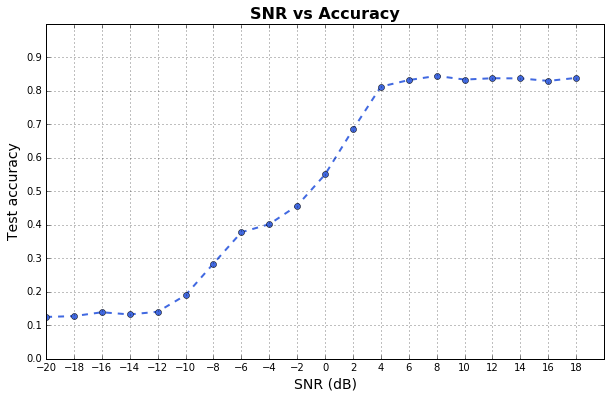

In [13]:
plt.style.use('classic')
%matplotlib inline

acc_test = sorted(acc_test.items())
new_acc = []
for i in range(len(acc_test)):
    new_acc.append(acc_test[i][1])
acc_test_values = new_acc 

fig1 = plt.figure(figsize=(10, 6), dpi=100)
x = snrs
y = list(acc_test_values)
plt.plot(x, y, marker="o", linewidth=2.0, linestyle='dashed', color='royalblue')
plt.axis([-20, 20, 0, 1])
plt.xticks(np.arange(min(x), max(x)+1, 2.0))
plt.yticks(np.arange(0, 1, 0.10))

ttl = plt.title('SNR vs Accuracy', fontsize=16)
ttl.set_weight('bold')
plt.xlabel('SNR (dB)', fontsize=14)
plt.ylabel('Test accuracy', fontsize=14)
plt.grid()

plt.show()

INFO:tensorflow:Restoring parameters from ./DNN4layer_regtech_l1
Confusion Matrix
       8PSK  BPSK  CPFSK  GFSK  PAM4  QAM16  QAM64  QPSK
8PSK   0.80  0.00   0.00  0.00  0.01   0.08   0.10   0.0
BPSK   0.00  0.99   0.00  0.00  0.00   0.00   0.00   0.0
CPFSK  0.01  0.00   0.97  0.01  0.00   0.01   0.00   0.0
GFSK   0.02  0.00   0.02  0.95  0.00   0.00   0.01   0.0
PAM4   0.00  0.02   0.00  0.00  0.98   0.00   0.00   0.0
QAM16  0.05  0.00   0.00  0.00  0.00   0.50   0.45   0.0
QAM64  0.02  0.00   0.00  0.00  0.00   0.47   0.51   0.0
QPSK   0.02  0.00   0.00  0.00  0.00   0.05   0.02   0.9


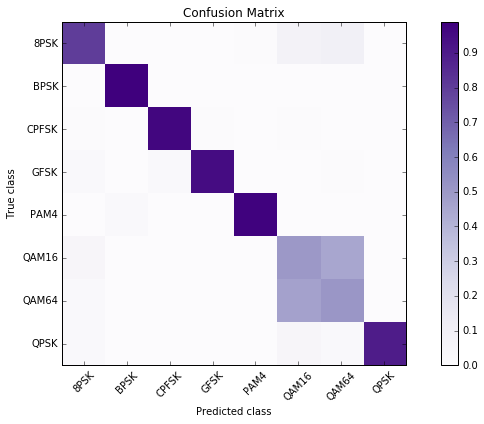

In [14]:
# Confusion Matrix

with tf.Session() as sess:
    saver.restore(sess, path)
    Z = logits.eval(feed_dict = {X : X_32test_std[18]})
    predicted_18dB = np.argmax(Z, axis = 1)
    
from sklearn.metrics import confusion_matrix
%matplotlib inline

classes = ['8PSK', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK']
conf_matrix = confusion_matrix(predicted_18dB, y_32_test[18])  

conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
conf_matrix = conf_matrix.round(decimals = 2)

import pandas as pd

df = pd.DataFrame(data = conf_matrix, columns = classes, index = classes) 
print("Confusion Matrix")
print(df)

fig1 = plt.figure(figsize=(10, 6), dpi=100)
plt.imshow(conf_matrix, interpolation = 'nearest', cmap = plt.cm.Purples)
ticks = np.arange(len(classes))
plt.title("Confusion Matrix")
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

plt.ylabel('True class')
plt.xlabel('Predicted class')

plt.tight_layout()
plt.colorbar()
plt.show()